<a href="https://colab.research.google.com/github/Sashank11/py/blob/master/Brain_Tumor_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Recognition with mri using Deep learning


### 19BCE2484 Sashank Rijal
### 19BCE2520 Mickey Kumar Rouniyar
### 19BCE2550 Prason Poudel

## Importing Dataset and Required Libraries 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [ ]:
import zipfile
file_name = "/content/drive/MyDrive/Copy of dataset.zip"

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Copy of dataset.zip")
zip_ref.extractall()
zip_ref.close()

## Getting the Data Ready.
 
1.   Load all training and testing data

2.   Pre-processing images

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images

5.   Dividing the dataset into Training and Validation sets





In [ ]:


labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

x_train = [] 
y_train  = [] 
x_test = [] 
y_test = [] 

image_size = 200


for label in labels:
    trainPath = os.path.join('/content/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) 
        image = cv2.bilateralFilter(image, 2, 50, 50) 
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) 
        image = cv2.resize(image, (image_size, image_size)) 
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/content/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 
x_test = np.array(x_test) / 

print(x_train.shape)
print(x_test.shape)

100%|██████████| 74/74 [00:00<00:00, 128.33it/s]


(2870, 200, 200, 3)
(394, 200, 200, 3)


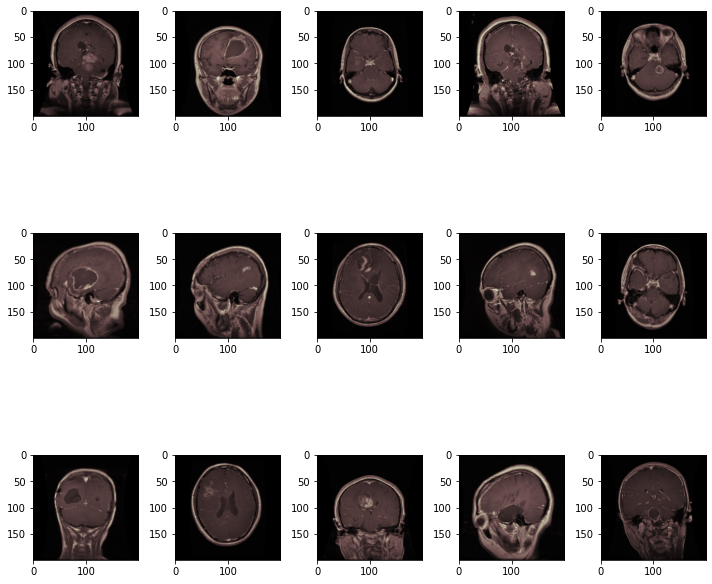

In [ ]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) 

print(x_val.shape)

(574, 200, 200, 3)


## Data Augmentation


In [ ]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## Building our Custom Model

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
input_shape=(574, 200, 200, 3)
custom_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10, 
                         kernel_size = 3,
                         activation = "relu",
                         input_shape = input_shape[1:]),
   tf.keras.layers.Conv2D(10, 3, activation = "relu"),
   tf.keras.layers.MaxPool2D(pool_size = 2,
                            padding = "valid"),
   tf.keras.layers.Conv2D(10, 3, activation = "relu"),
   tf.keras.layers.Conv2D(10, 3, activation = "relu"),
   tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])
custom_model.compile(loss = "categorical_crossentropy",
             optimizer = "adam", 
             metrics = ["accuracy"])

In [ ]:
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_c = custom_model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS)

Epoch 1/50
115/115 [==============================] - 33s 189ms/step - loss: 1.0809 - accuracy: 0.5030 - val_loss: 0.8086 - val_accuracy: 0.6324
Epoch 2/50
115/115 [==============================] - 19s 168ms/step - loss: 0.8324 - accuracy: 0.6394 - val_loss: 0.7358 - val_accuracy: 0.6638
Epoch 3/50
115/115 [==============================] - 20s 173ms/step - loss: 0.7317 - accuracy: 0.6790 - val_loss: 0.6829 - val_accuracy: 0.6934
Epoch 4/50
115/115 [==============================] - 19s 161ms/step - loss: 0.6981 - accuracy: 0.6999 - val_loss: 0.6285 - val_accuracy: 0.7474
Epoch 5/50
115/115 [==============================] - 19s 162ms/step - loss: 0.6414 - accuracy: 0.7217 - val_loss: 0.5861 - val_accuracy: 0.7509
Epoch 6/50
115/115 [==============================] - 19s 163ms/step - loss: 0.6043 - accuracy: 0.7426 - val_loss: 0.5548 - val_accuracy: 0.7509
Epoch 7/50
115/115 [==============================] - 19s 161ms/step - loss: 0.5789 - accuracy: 0.7548 - val_loss: 0.5492 - val_ac

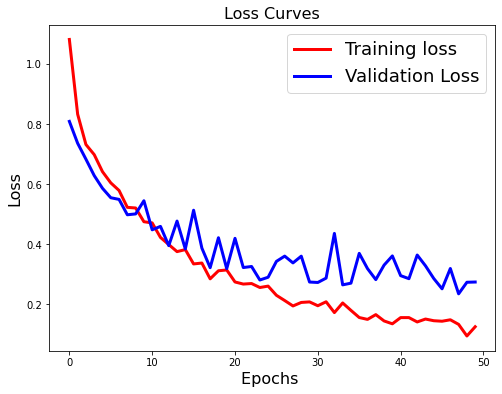

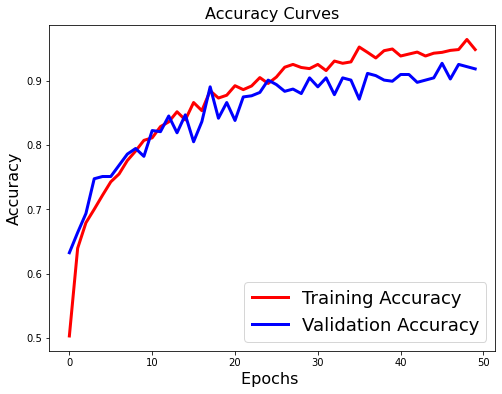

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_c.history['loss'],'r',linewidth=3.0)
plt.plot(history_c.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_c.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_c.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       186
           1       0.88      0.87      0.88       158
           2       0.87      0.96      0.91        71
           3       0.96      0.96      0.96       159

    accuracy                           0.92       574
   macro avg       0.91      0.92      0.92       574
weighted avg       0.92      0.92      0.92       574



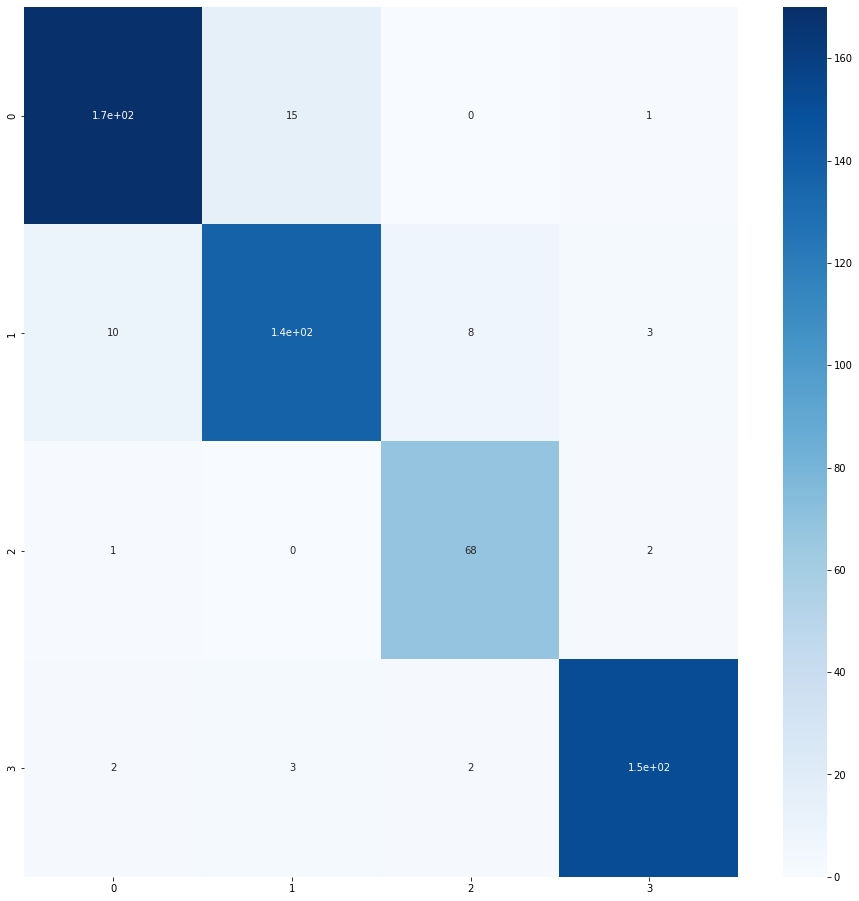

In [ ]:
predicted_classes = np.argmax(custom_model.predict(x_val), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_val,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_val,axis=1), predicted_classes))

In [ ]:
loss,acc = custom_model.evaluate(x_val,y_val)

18/18 [==============================] - 0s 20ms/step - loss: 0.2746 - accuracy: 0.9181


## Transfer Learning RestNet 50

In this project, We be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




In [ ]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:

#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_1 = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8275
Epoch 1: val_loss improved from inf to 13.72125, saving model to model-01-0.12-13.72.h5
115/115 [==============================] - 68s 370ms/step - loss: 0.4584 - accuracy: 0.8275 - val_loss: 13.7213 - val_accuracy: 0.1237 - lr: 1.0000e-04
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9347
Epoch 2: val_loss improved from 13.72125 to 8.99313, saving model to model-02-0.12-8.99.h5
115/115 [==============================] - 37s 323ms/step - loss: 0.2050 - accuracy: 0.9347 - val_loss: 8.9931 - val_accuracy: 0.1237 - lr: 1.0000e-04
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9495
Epoch 3: val_loss improved from 8.99313 to 6.05188, saving model to model-03-0.12-6.05.h5
115/115 [==============================] - 38s 331ms/step - loss: 0.1479 - accuracy: 0.9495 - val_loss: 6.0519 - val_accuracy: 0.1237 - lr: 

## Learning curves

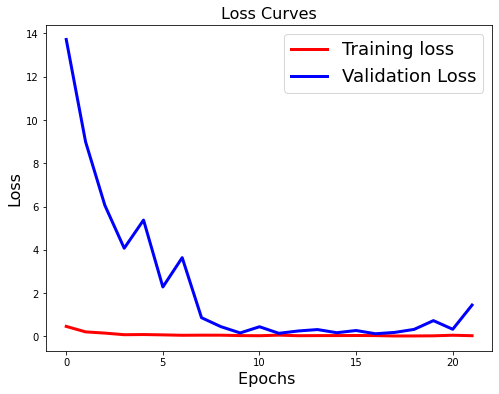

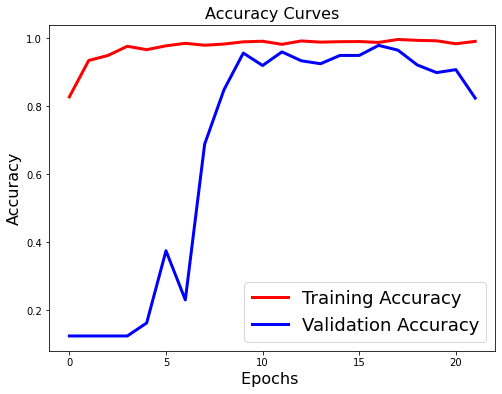

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['loss'],'r',linewidth=3.0)
plt.plot(history_1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       186
           1       0.97      0.97      0.97       158
           2       0.99      0.97      0.98        71
           3       0.98      0.99      0.98       159

    accuracy                           0.98       574
   macro avg       0.98      0.98      0.98       574
weighted avg       0.98      0.98      0.98       574



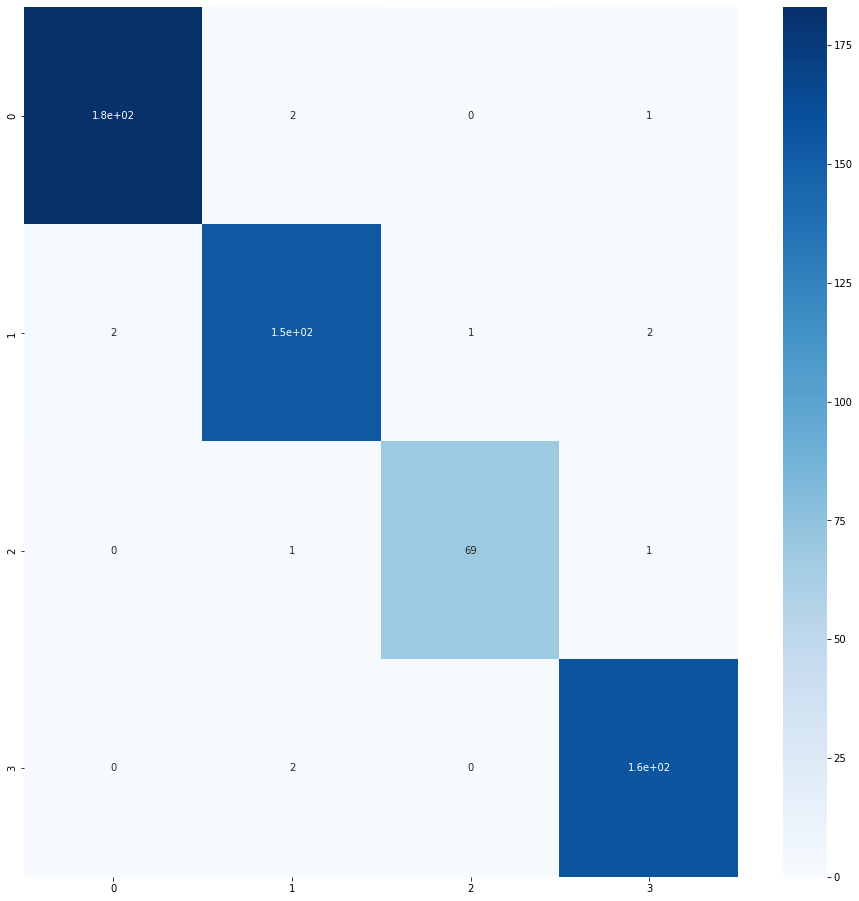

In [ ]:
predicted_classes = np.argmax(model.predict(x_val), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_val,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_val,axis=1), predicted_classes))

In [ ]:
loss,acc = model.evaluate(x_val,y_val)

18/18 [==============================] - 2s 96ms/step - loss: 0.1187 - accuracy: 0.9791


## Transfer Learning Inception_v3

In [ ]:
inception = InceptionV3(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# # Run tensorBoard
# %tensorboard --logdir logs

In [ ]:
model_3 = inception.output
model_3 = GlobalAveragePooling2D()(model_3)
model_3 = Dropout(0.1)(model_3)
model_3 = Dense(4, activation="softmax")(model_3)
model_3 = Model(inputs= inception.input, outputs= model_3)

#compile our model.
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
model_3.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 25

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_3 = model_3.fit(datagen.flow(x_train, y_train, batch_size=20),epochs = EPOCHS)

Epoch 1/25
115/115 [==============================] - 34s 217ms/step - loss: 6.2513 - accuracy: 0.2992
Epoch 2/25
115/115 [==============================] - 24s 209ms/step - loss: 3.0906 - accuracy: 0.2927
Epoch 3/25
115/115 [==============================] - 23s 198ms/step - loss: 2.8818 - accuracy: 0.3062
Epoch 4/25
115/115 [==============================] - 23s 198ms/step - loss: 2.1145 - accuracy: 0.2931
Epoch 5/25
115/115 [==============================] - 23s 198ms/step - loss: 2.2783 - accuracy: 0.3044
Epoch 6/25
115/115 [==============================] - 23s 197ms/step - loss: 1.7154 - accuracy: 0.3349
Epoch 7/25
115/115 [==============================] - 23s 202ms/step - loss: 1.6593 - accuracy: 0.3763
Epoch 8/25
115/115 [==============================] - 23s 200ms/step - loss: 1.4396 - accuracy: 0.3911
Epoch 9/25
115/115 [==============================] - 23s 197ms/step - loss: 1.5006 - accuracy: 0.3990
Epoch 10/25
115/115 [==============================] - 23s 196ms/step - l

## Log confusion matrix to TensorBoard

With the following code you can log the confusion matrix for all epochs.